# Model Run 1

Original author **Romain Beucher** romain.beucher@anu.edu.au
Edited by **Mitchell McMillan**

The following notebook is an implementation of the Numerical Sandbox Extension Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

The test has been implemented using Fantom in [Thieulot, 2011](http://linkinghub.elsevier.com/retrieve/pii/S0031920111001336) and more recently with Aspect in [Glerum et al., 2017](http://www.solid-earth-discuss.net/se-2017-9). 

## Model geometry

Set-up of the extension experiment. A viscous layer (PDMS, 10 x 0.5 cm) lies in the central part of the model on the base. The rest of the model consists of three ‘sand’ layers (only differing in colour). Extension is achieved by moving the right wall with the attached 10 cm long sheet outwards to the right.

<img src="images/Extension.png" width=800>

## Results of various models

**A:**  Final geometry after 1 hour of simulated time.
**B:**  Strain rate (warmer colors = higher extension rate) after 1 hour of simulated time.
From Buiter et al. (2006).

What are the main differences among the different models?

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 

## Running the experiment in Underworld 2

The following code walk through implementing this experiment in Underworld 2.
Note that the output of each cell is already printed below it, so we don't actually have to run this code.
But you can run each code chunk by selecting the cell and hitting Shift+Enter.

In [1]:
import UWGeodynamics as GEO
u = GEO.UnitRegistry

velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

loaded rc file /opt/venv/lib/python3.8/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [ ]:
Model = GEO.Model(elementRes=(120, 30), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(20. * u.centimeter, 1.5 * u.centimeter), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

Model.mesh_advector(axis=0)
Model.add_visugrid(elementRes=(120, 30), 
                   minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                   maxCoord=(20. * u.centimeter, 0.0 * u.centimeter))

## Add some Materials

Now that we have our box ready, we need to fill it with some materials.
A material is first defined by its shape.

In [3]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
sand1 = Model.add_material(name="Sand1", shape=GEO.shapes.Layer(top=0.*u.centimeter, bottom=Model.bottom))
sand2 = Model.add_material(name="Sand2", shape=GEO.shapes.Layer(top=-1. * u.centimeter, bottom=-2. * u.centimeter))

vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

silicon = Model.add_material(name="Silicon", shape=GEO.shapes.Polygon(vertices))

## Passive Tracers

We add "passive tracers" along layer boundaries. The tracers don't affect the results in any way - they just help us visualize the layers.

In [4]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(sand1.top)

Model.add_passive_tracers(name="Interface1", vertices=coords)

coords[:, 1] = GEO.nd(sand2.top)
Model.add_passive_tracers(name="Interface2", vertices=coords)

coords[:, 1] = GEO.nd(sand2.bottom)
Model.add_passive_tracers(name="Interface3", vertices=coords)


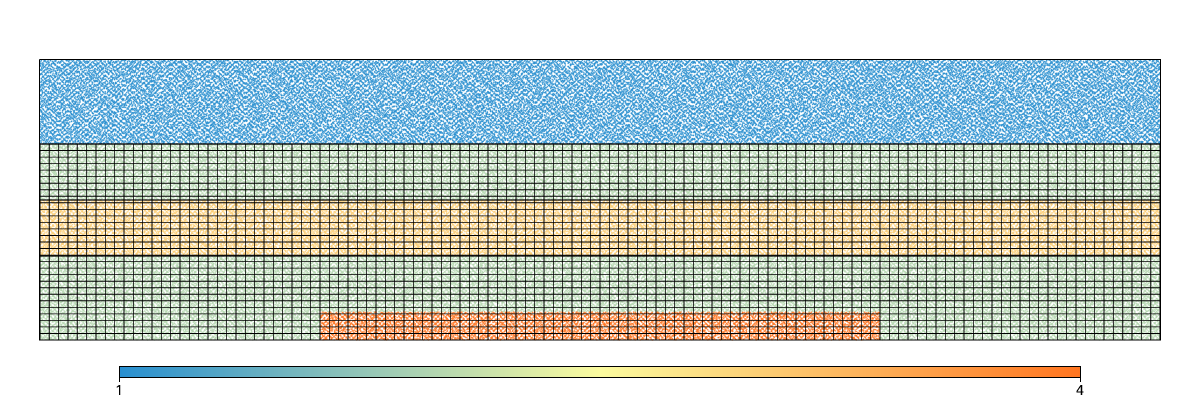

In [5]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
properties = {"linewidth":0.35}
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface2_tracers, pointSize=2.0)
Fig.Points(Model.Interface3_tracers, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model._visugrid.mesh, lineWidth=0.5)
Fig.properties=properties
Fig.show()

## Material behaviour

Each material is given a viscosity and a density.
Viscosities can be defined as a constant value, but it is also possible to load predefined rheologies from the `rheology library`. The predefined rheologies are functions of temperature, pressure, and other factors.

For our purposes, constant viscosities are probably appropriate. **(Why?)**

In [6]:
# Define densities
air.density = 10. * u.kilogram / u.metre**3
sand1.density = 1560. * u.kilogram / u.metre**3
sand2.density = 1560. * u.kilogram / u.metre**3
silicon.density = 965. * u.kilogram / u.metre**3

# Define viscosities
air.viscosity     = 1.0e2  * u.pascal * u.second
sand1.viscosity   = 1.0e13 * u.pascal * u.second
sand2.viscosity   = 1.0e13 * u.pascal * u.second
silicon.viscosity = 5.0e4  * u.pascal * u.second

## Model plastic deformation

Unlike elastic deformation, plastic deformation is permanent (and so is viscous deformation). 
In models, what sets plastic deformation apart from viscous flow is the idea of a yield stress.
The yield stress is a stress threshold, below which no plastic deformation takes place (the material can still deform by viscous flow).
Above the yield stress, the material deforms according to a plastic flow law.

### The Ducker-Prager yeild stress

The most common type of plastic yield stress in geodynamic simulations is a Drucker-Prager relationship.
The yield stress $\sigma_y$ is defined as

$$
\sigma_y = C \cos \phi + P\sin \phi
$$

where $C$ is cohesion, $\phi$ is friction angle, and $P$ is pressure.
Pressure is one of the variables the model must solve for.
The main parameters we can control are $C$ and $\phi$.
For both quantities, higher values increase the yield stress, producing a stronger plastic material.

Rocks commonly have $C$ values between zero and 20 MPa and $\phi$ between 2 and 30 degrees (~0.5 radians).
Our room temperature sand here is a bit different from rocks at high pressures and temperatures.
Perfectly dry sand would have a cohesion close to zero (any moisture and interparticle electrostatic forces would increase it a bit).
Friction angle depends on things like grain size, sorting, and shape, but it is generally pretty high in sand.
The angle of repose approximates the friction angle, and sand has an angle of repose between 30 and 45 degrees (~0.5 to 0.8 radians), depending on how wet it is.

### Strain softening

Plastic yielding in models is supposed to approximate the behavior of brittle faults in the real world.
Even though the two processes (plastic yielding and brittle failure) are quite different in reality, computer models can't handle actual discontinuities very well (such as a brittle fault plane).

To approximate the behavior of faults, we can tweak the plastic yielding algorithm.
One important characteristic of faults is that, after they form, they become planes of weakness that can be reactivated multiple times during deformation.
As deformation continues, new faults will only be broken if the existing fault planes are not oriented favorably; otherwise, the deformation will concentrate on existing faults.
This would have the effect of localizing strain (increasing strain rate) to a few structures, rather than to the entire model domain.

We introduce strain softening into our plastic deformation scheme to get a similar effect.
The model keeps track of the amount of plastic strain at each location, allowing us to reduce the cohesion and/or friction parameters in the Drucker-Prager relationship.
With increasing strain, the friction angle or cohesion decreases toward zero, making the strained material weaker (more easily deformed by plastic yielding).
Essentially, the first time the material is strained, it will be relatively strong and resist deformation; the next time, it will be a bit weaker and easier to deform; the third time, it will be even weaker, and so on.

In [7]:
sandPlasticity = GEO.DruckerPrager(cohesion=10. * u.pascal, # Cohesion before strain softening
                                   cohesionAfterSoftening=10. * u.pascal,
                                   frictionCoefficient=0.73, # Friction before strain softening
                                   frictionAfterSoftening=0.60)

sand1.plasticity = sandPlasticity
sand2.plasticity = sandPlasticity

## Boundary conditions

Here we set the velocity along the edges of the model to make the right wall move to the right.

In [8]:
import underworld.function as fn

conditions = [(Model.x > GEO.nd(10.1 * u.centimetre), GEO.nd(2.5 * u.centimeter / u.hour)),
              (Model.x > GEO.nd(9.9 * u.centimetre), (Model.x - GEO.nd(9.9 * u.centimetre)) * GEO.nd(velocity) / GEO.nd(0.2 * u.centimetre)),
              (True, 0.0)]

fn_condition = fn.branching.conditional(conditions)

Model.set_velocityBCs(left=[0 * u.centimeter / u.hour, None],
                      right=[2.5 * u.centimeter / u.hour, None],
                      bottom=[fn_condition, 0.0])

## Initialise Model

The model is initialized, solving the initial steady state temperature field and the pressure field.

In [9]:
Model.minViscosity = 1.0e2 * u.pascal * u.second
Model.maxViscosity = 1.0e9 * u.pascal * u.second

Model.init_model(pressure="lithostatic")

/opt/venv/lib/python3.8/site-packages/UWGeodynamics/_model.py:1551: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")



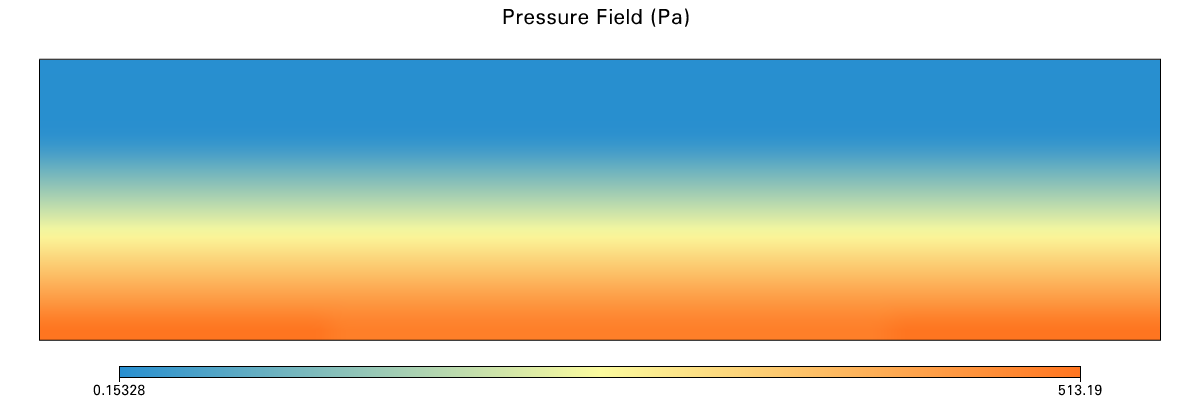

In [10]:
FigPressure = vis.Figure(figsize=(1200, 400), title="Pressure Field (Pa)", quality=3)
FigPressure.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.pascal))
FigPressure.show()


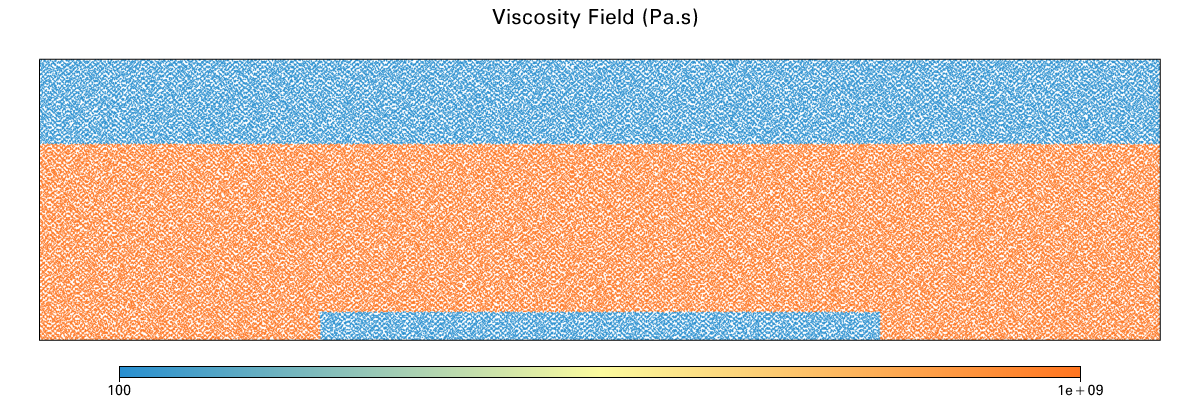

In [11]:
FigViscosity = vis.Figure(figsize=(1200, 400), title="Viscosity Field (Pa.s)", quality=3)
FigViscosity.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal * u.second), pointSize=2.0)
FigViscosity.show()

## Run the model

We run the model for 1 hour, then look at the results.

In [12]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
Model.run_for(1.0 * u.hours)

Running with UWGeodynamics version 2.11.0-dev-485ad28(master)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 2.0 minute dt: 2.0 minute (2021-11-19 23:37:51)
Step:     2 Model Time: 4.0 minute dt: 2.0 minute (2021-11-19 23:38:15)
Step:     3 Model Time: 6.0 minute dt: 2.0 minute (2021-11-19 23:38:35)
Step:     4 Model Time: 8.0 minute dt: 2.0 minute (2021-11-19 23:38:56)
Step:     5 Model Time: 10.0 minute dt: 2.0 minute (2021-11-19 23:39:20)
Step:     6 Model Time: 10.0 minute dt: 1.2 second (2021-11-19 23:41:37)
Step:     7 Model Time: 12.0 minute dt: 2.0 minute (2021-11-19 23:42:18)
Step:     8 Model Time: 14.0 minute dt: 2.0 minute (20

1


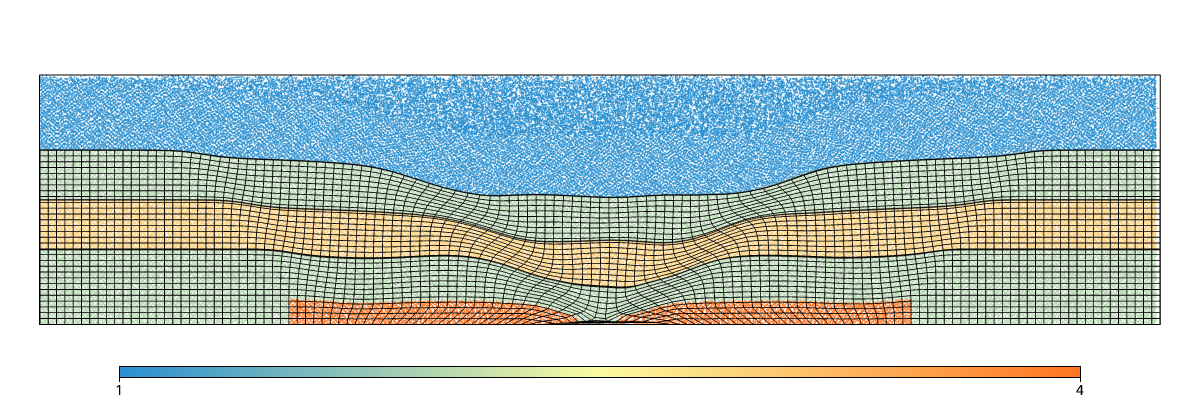

In [13]:
# Show figure of layer geometry
Fig.show()


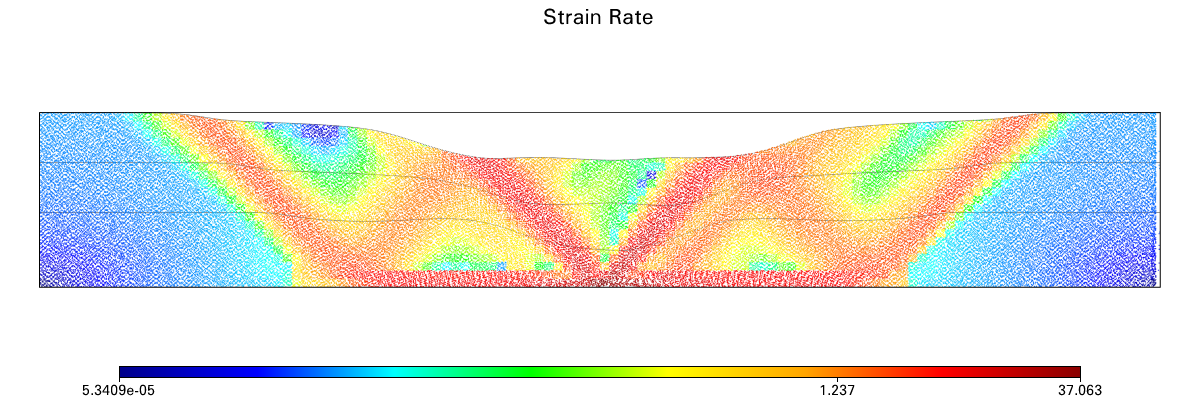

In [14]:
# Create figure for strain rate

fn = GEO.uw.function

map_dict = {
    air.index: 0.,
    sand1.index: 1.,
    sand2.index: 1.,
    silicon.index: 1.
}
mask = fn.branching.map(fn_key=Model.materialField, mapping=map_dict)

FigStrainRate = vis.Figure(figsize=(1200, 400), title="Strain Rate", quality=3)
FigStrainRate.Points(Model.swarm, fn_colour=Model.strainRateField, fn_mask=mask, pointSize=1.5, logScale=True, colours="darkblue blue cyan green yellow orange red darkred")
FigStrainRate.Points(Model.Interface1_tracers)
FigStrainRate.Points(Model.Interface2_tracers)
FigStrainRate.Points(Model.Interface3_tracers)
FigStrainRate.show()

## Compare these results to other models

Here again are the same plots for the other models. 

- How do our results compare? 
- If we assume that the actual sandbox would display brittle faults and highly localized strain, which models seem to reproduce that best? 
- Is there anything that is questionable about *all* the models, and would suggest a weakness in the modelling approach in general?

*After exploring these questions, open `model-run-2.ipynb`.*

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 